# Tutorial: Cut Relaxation with MellowGate

Welcome to this tutorial on MellowGate, a Python library designed to make discrete optimization problems differentiable. In this tutorial, we will explore how MellowGate can be used to relax discrete decisions, enabling gradient-based optimization techniques to be applied to problems that involve hard thresholds or categorical choices.

## Why Discrete Optimization Matters
Discrete optimization problems involve decision variables that take on discrete values, such as binary choices or categorical options. These problems are common in fields like operations research, machine learning, and control systems. However, the discrete nature of these decisions makes them non-differentiable, posing challenges for gradient-based optimization methods.

## The Role of Cut Relaxation
Cut relaxation is a technique that approximates discrete decisions with continuous functions. By relaxing the hard boundaries of discrete decisions, we can compute gradients and apply optimization algorithms. This tutorial focuses on three methods for cut relaxation:
1. **Hard Cuts**: The baseline method with strict thresholds.
2. **Sigmoid Relaxation**: A smooth approximation using the sigmoid function.
3. **Stochastic Relaxation**: A probabilistic approach based on logits.

## Defining a Discrete Problem

Discrete optimization problems involve decision variables that can take on a finite set of values. For example, in a binary decision problem, the variable can only be 0 or 1. These problems are common in optimization tasks where the goal is to find the best combination of discrete choices to maximize or minimize an objective function.

### What Are Logits?
Logits are unnormalized scores or raw predictions produced by a model. They are often used as inputs to compute probabilities. For example, in a classification problem, logits represent the relative confidence of the model for each class before normalization.

### How Logits Relate to Probabilities
Logits can be transformed into probabilities using various methods. The most common method is the softmax function, which ensures that the probabilities are non-negative and sum to 1. Mathematically, the softmax function is defined as:
$$
P(y_i) = \frac{\exp(z_i)}{\sum_{j=1}^n \exp(z_j)}
$$
where:
- $z_i$ are the logits for each class $i$.
- $P(y_i)$ is the probability of class $i$.

Other methods include:
- **Sigmoid Function**: Often used for binary classification, where the probability is computed as:
  $$
  P(y) = \frac{1}{1 + \exp(-z)}
  $$
- **Temperature Scaling**: Adjusting the sharpness of the distribution by dividing logits by a temperature parameter $T$ before applying softmax. For example:
  $$
  P(y_i) = \frac{\exp(z_i / T)}{\sum_{j=1}^n \exp(z_j / T)}
  $$
  A lower $T$ sharpens the distribution, making the probabilities more confident, while a higher $T$ smoothens the distribution.

### Translating Function Arguments to Logits
In discrete optimization, logits are often derived from the problem's parameters or function arguments. For example, consider a problem where the logits depend on a parameter $\theta$:
$$
\alpha_k(\theta) = \begin{cases}
-\theta, & \text{if } k = 0, \\
\theta, & \text{if } k = 1.
\end{cases}
$$
Here, $\alpha_k(\theta)$ represents the logits for branch $k$, and $\theta$ determines the relative likelihood of each branch. This mapping from $\theta$ to logits is crucial for defining the probability distribution over branches.

In the context of MellowGate, logits are used to define the probability distribution over discrete branches. These probabilities are then used for sampling and gradient estimation.

### Transition to MellowGate
Now that we understand the basics of discrete problems and logits, let’s explore how MellowGate provides tools to tackle these challenges effectively. We will define branches, logits, and discrete problems using MellowGate’s API.

In [1]:
# Import necessary libraries
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mellowgate.api.estimators import (
    GumbelSoftmaxConfig,
    ReinforceConfig,
    ReinforceState,
    gumbel_softmax_gradient,
    reinforce_gradient,
)
from mellowgate.api.functions import Branch, DiscreteProblem, LogitsModel
from mellowgate.utils.outputs import OutputManager
import matplotlib.font_manager as fm
from cycler import cycler

# Initialize output manager
output_manager = OutputManager(base_directory="outputs")

In [2]:
# Define helper functions
# Correct the apply_gill_sans_font function to ensure the legend splits into 3 columns and increases font size
gs_font = fm.FontProperties(fname="/System/Library/Fonts/Supplemental/GillSans.ttc")

def apply_gill_sans_font(ax, legloc=None):
    """Apply Gill Sans font and font size to axis labels, tick labels, and legend."""
    ax.set_xlabel(
        ax.get_xlabel(), fontproperties=gs_font, fontsize=13
    )  # Adjust font size
    ax.set_ylabel(
        ax.get_ylabel(), fontproperties=gs_font, fontsize=13
    )  # Adjust font size
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(gs_font)
        label.set_fontsize(12)  # Adjust tick label font size

    # Update legend to use Gill Sans font, split into 3 columns, and increase font size
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontproperties(gs_font)
            text.set_fontsize(12)  # Increase legend font size
        legend.set_frame_on(True)  # Enable legend frame
        legend.get_frame().set_edgecolor("none")  # Remove box edge
        legend.get_frame().set_linewidth(0)  # Set frame line width to 0
        if legloc is None:
            legend.set_bbox_to_anchor((0.0, 1.1))  # Position above the top axis
        legend.set_loc("upper left")  # Center the legend horizontally

## Mathematical Formulation of Cut Relaxation

Cut relaxation is a technique used to soften the boundaries of data filtering. Here, we explore three methods:

1. **Hard Cut**: A strict threshold-based filtering defined as:
   $$
   f(x) = \begin{cases} 
   1 & \text{if } x > \text{threshold} \\
   0 & \text{otherwise}
   \end{cases}
   $$

2. **Sigmoid Relaxation**: A smooth approximation using the sigmoid function:
   $$
   f(x) = \frac{1}{1 + e^{-\frac{x - \text{threshold}}{T}}}
   $$
   Here, $T$ is the temperature parameter that controls the sharpness of the transition. A smaller $T$ results in a sharper transition, making the sigmoid function resemble a hard cut, while a larger $T$ smoothens the transition.

3. **Stochastic Relaxation**: A probabilistic approach where data points are sampled based on logits and probabilities.

### Logits Definition and Choice
Logits are unnormalized scores that determine the relative likelihood of each branch in the stochastic relaxation method. The choice of logits is critical as it directly influences the probabilities assigned to each branch. For example, logits can be defined as:
$$
\alpha_k(x) = \begin{cases}
\frac{x - \text{threshold}}{T}, & \text{if } k = 0, \\
-\frac{x - \text{threshold}}{T}, & \text{if } k = 1.
\end{cases}
$$
where:
- $\theta$ is the input parameter.
- $\text{threshold}$ is the decision boundary.
- $c$ is a scaling factor that controls the sharpness of the logits.

This choice ensures that the logits are symmetric around the threshold, with higher values of $\theta$ favoring branch 1 and lower values favoring branch 0. This happens because as $\theta$ increases, the logits for branch 1 ($\frac{\theta - \text{threshold}}{c}$) become larger, while the logits for branch 0 ($-\frac{\theta - \text{threshold}}{c}$) become smaller. Consequently, the probability of selecting branch 1 increases, as it is proportional to the exponential of its logits.

In [3]:
# Set up mellowgate problem
def pass_branch(data):
    """Branch for passing the data point."""
    return jnp.ones_like(data)


def fail_branch(data):
    """Branch for failing the data point."""
    return jnp.zeros_like(data)

branches = [
    Branch(function=pass_branch, derivative_function=lambda x: jnp.zeros_like(x)),
    Branch(function=fail_branch, derivative_function=lambda x: jnp.zeros_like(x)),
]

threshold = 0.0
temp = 0.1
logits_model = LogitsModel(
    logits_function=lambda th: jnp.array(
        [(th - threshold) / temp, -(th - threshold) / temp]
    ),
    logits_derivative_function=lambda th: jnp.array(
        [jnp.ones_like(th)/temp, -jnp.ones_like(th)/temp]
    ),
    probability_function=lambda logits: 1.0 / (1 + jnp.exp(-logits)),
)

def bernoulli_sampling_function(probs: jnp.ndarray, key: jax.Array):
    """Custom sampling function that works with the vectorized pipeline."""
    # jax.random.choice expects (key, a, shape=(), replace=True, p=probabilities)
    return jax.random.choice(key, len(probs), p=probs)

# Now using the custom sampling function with vectorized performance
problem = DiscreteProblem(branches=branches,
                          logits_model=logits_model,
                          sampling_function=bernoulli_sampling_function
                          )

In [4]:
# Generate synthetic data
data = jnp.linspace(-3, 3, 100000)

In [5]:
# Apply cuts
hard_cut_result = data[data > threshold]
sigmoid_weights = 1 / (1 + jnp.exp(-(data - threshold)/temp))
sigmoid_result = data

# Sample branch indices using mellowgate
num_samples = 1
key = jax.random.PRNGKey(0)
sampled_branch_indices = problem.sample_branch(data, num_samples=num_samples, key=key)

# Filter data based on sampled indices (JAX-compatible approach)
# Create a boolean mask where True means the data point passes (branch_idx == 0)
pass_mask = sampled_branch_indices.flatten() == 0
stochastic_result = data[pass_mask]

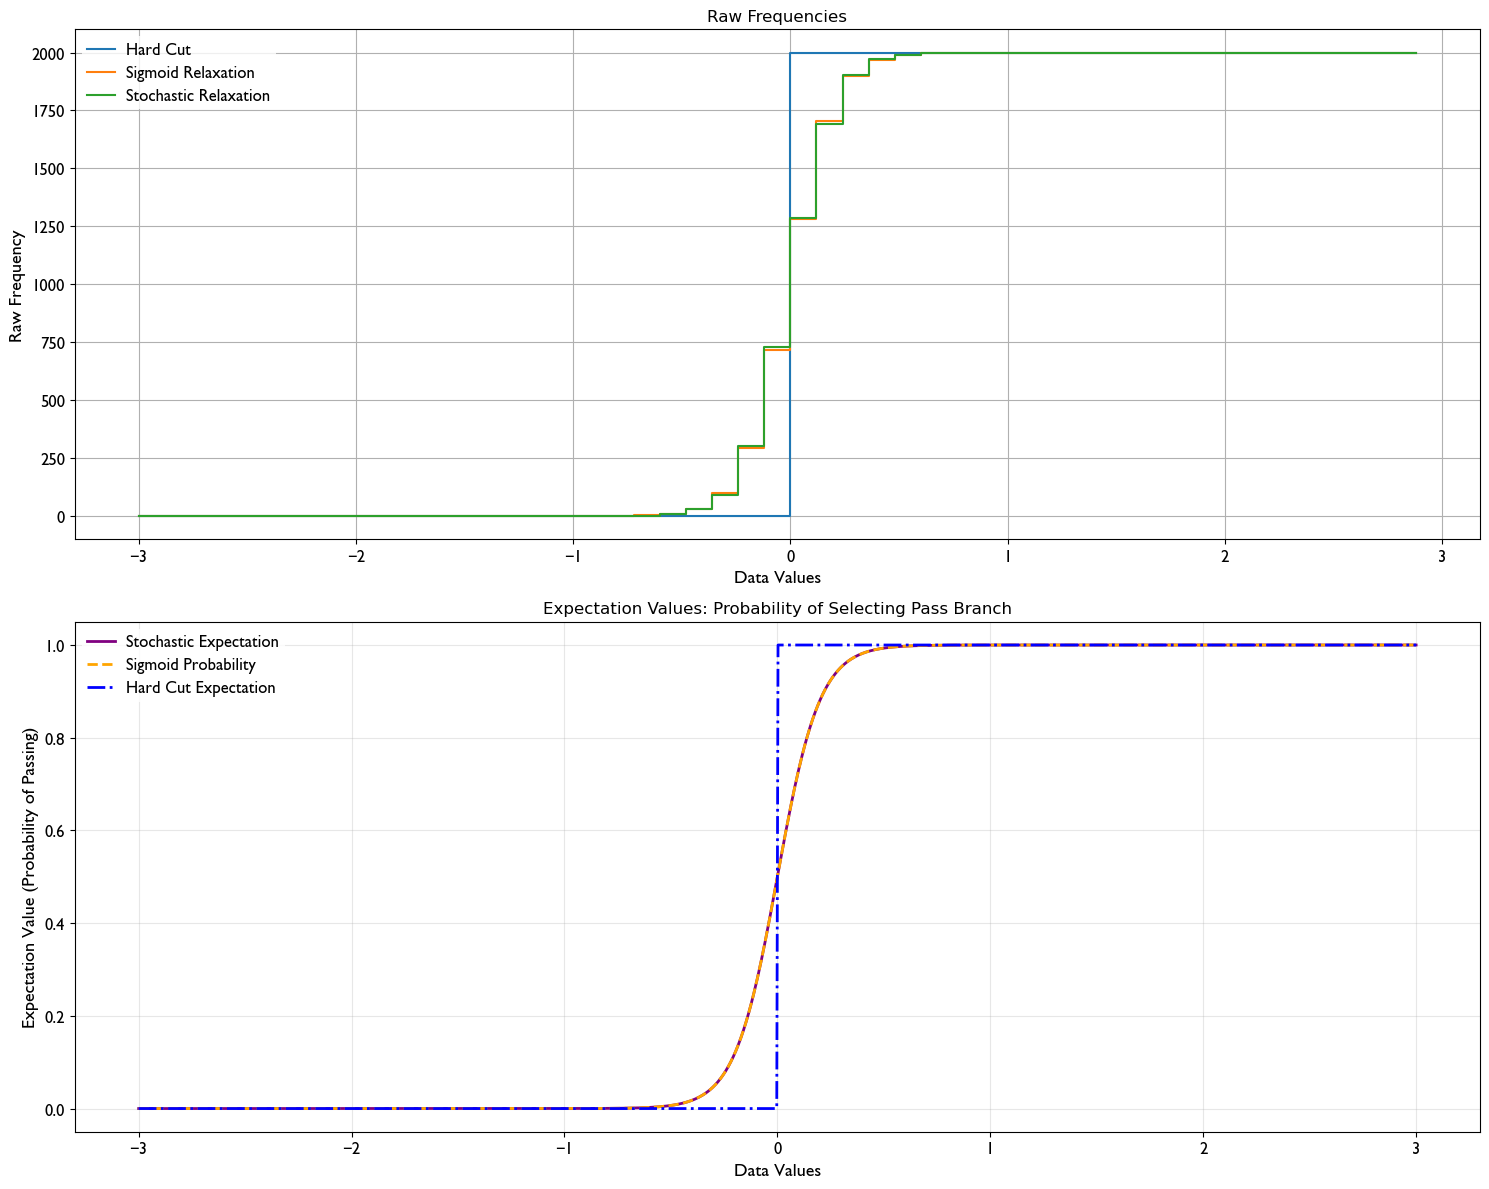

Expected value statistics:
  Mean expectation: 0.5000
  Min expectation:  0.0000
  Max expectation:  1.0000
  Threshold crossing at data = 0.0: E[f] = 0.5000


In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top plot: Raw frequencies
bins = jnp.linspace(-3, 3, 51)
hard_cut_counts, hard_cut_bins = jnp.histogram(hard_cut_result, bins=bins)
ax1.plot(hard_cut_bins[:-1], hard_cut_counts, label="Hard Cut", drawstyle="steps-post")

sigmoid_counts, sigmoid_bins = jnp.histogram(sigmoid_result, bins=bins, weights=sigmoid_weights)
ax1.plot(sigmoid_bins[:-1], sigmoid_counts, label="Sigmoid Relaxation", drawstyle="steps-post")

stochastic_counts, stochastic_bins = jnp.histogram(stochastic_result, bins=bins)
ax1.plot(stochastic_bins[:-1], stochastic_counts, label="Stochastic Relaxation", drawstyle="steps-post")

ax1.set_xlabel("Data Values")
ax1.set_ylabel("Raw Frequency")
ax1.legend(fontsize=10)
ax1.grid(True)
ax1.set_title("Raw Frequencies")

apply_gill_sans_font(ax1, legloc="upper left")

# Bottom plot: Expectation values (probability of passing)
# Compute expectation values for a subset of data for cleaner visualization
data_subset = jnp.linspace(-3, 3, 1000)
expected_values = problem.compute_expected_value(data_subset)

# Also compute the sigmoid probability for comparison
sigmoid_probs = 1 / (1 + jnp.exp(-(data_subset - threshold)/temp))

# Hard cut expectation (step function)
hard_cut_expectation = (data_subset > threshold).astype(float)

ax2.plot(data_subset, expected_values, label="Stochastic Expectation", color="purple", linewidth=2)
ax2.plot(data_subset, sigmoid_probs, label="Sigmoid Probability", color="orange", linewidth=2, linestyle="--")
ax2.plot(data_subset, hard_cut_expectation, label="Hard Cut Expectation", color="blue", linewidth=2, linestyle="-.")

ax2.set_xlabel("Data Values")
ax2.set_ylabel("Expectation Value (Probability of Passing)")
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_title("Expectation Values: Probability of Selecting Pass Branch")
ax2.set_ylim(-0.05, 1.05)

apply_gill_sans_font(ax2, legloc="upper left")

plt.tight_layout()
plt.show()

# Print some key statistics
print(f"Expected value statistics:")
print(f"  Mean expectation: {jnp.mean(expected_values):.4f}")
print(f"  Min expectation:  {jnp.min(expected_values):.4f}")
print(f"  Max expectation:  {jnp.max(expected_values):.4f}")
print(f"  Threshold crossing at data = {threshold}: E[f] = {problem.compute_expected_value(jnp.array([threshold]))[0]:.4f}")

/var/folders/0v/cvfdg7wn2k59f7d0pp1wdsy80000gn/T/ipykernel_464/169868649.py:7: RuntimeWarning: Gumbel-Softmax gradient estimation produced 1 NaN values out of 100000 parameter points. This typically occurs with extreme logit values and high sample counts. Consider reducing num_samples (current: 500) or adjusting temperature (current: 0.5). NaN values will be replaced with 0.0.
  gradient_gumbel = gumbel_softmax_gradient(problem, data, config=config_gumbel)


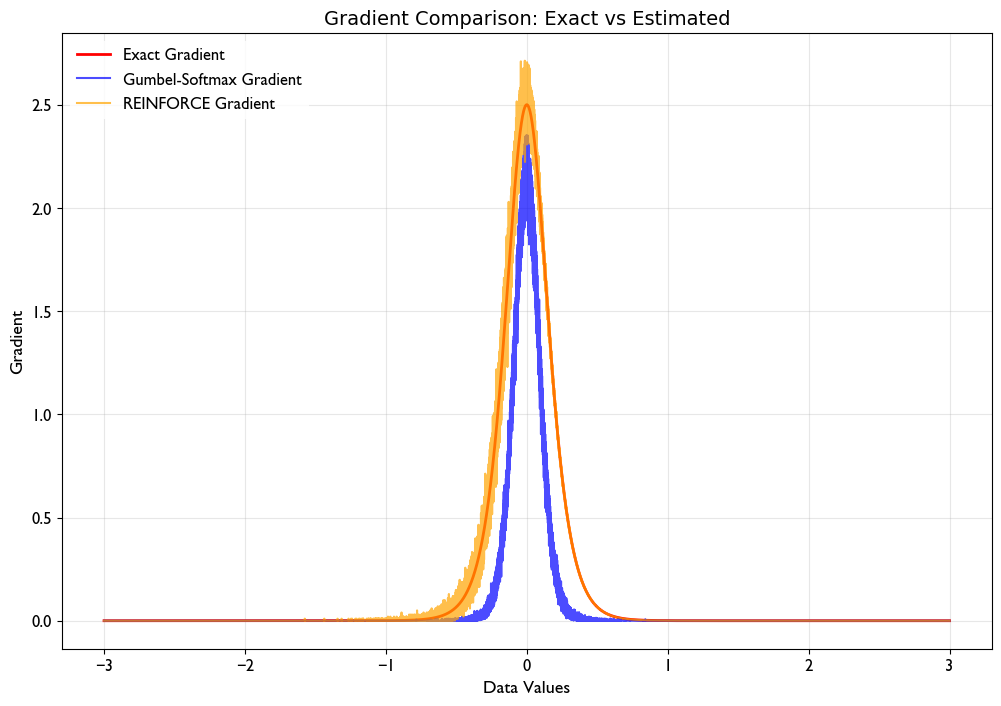

Exact gradient statistics:
  Mean: 0.166665
  Std:  0.499998
  Max:  2.500000

Gumbel-Softmax gradient statistics:
  Mean: 0.083219
  Std:  0.338349
  MSE vs exact: 0.05355292

REINFORCE gradient statistics:
  Mean: 0.166740
  Std:  0.500982
  MSE vs exact: 0.00053324


In [7]:
# Gradient comparison
config_gumbel = GumbelSoftmaxConfig(temperature=0.5, num_samples=500, use_straight_through_estimator=True)
config_reinforce = ReinforceConfig(num_samples=1000, use_baseline=False)
state_reinforce = ReinforceState()

# Compute gradient estimates
gradient_gumbel = gumbel_softmax_gradient(problem, data, config=config_gumbel)
gradient_reinforce = reinforce_gradient(problem, data, config=config_reinforce, state=state_reinforce)

# Compute exact gradient using MellowGate's built-in method
exact_gradient = problem.compute_exact_gradient(data)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data, exact_gradient, label="Exact Gradient", color="red", linewidth=2, linestyle="-")
ax.plot(data, gradient_gumbel, label="Gumbel-Softmax Gradient", color="blue", alpha=0.7)
ax.plot(data, gradient_reinforce, label="REINFORCE Gradient", color="orange", alpha=0.7)

ax.set_xlabel("Data Values")
ax.set_ylabel("Gradient")
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_title("Gradient Comparison: Exact vs Estimated", fontsize=14)

apply_gill_sans_font(ax, legloc="upper left")
plt.show()

# Print some statistics for comparison
print(f"Exact gradient statistics:")
print(f"  Mean: {jnp.mean(exact_gradient):.6f}")
print(f"  Std:  {jnp.std(exact_gradient):.6f}")
print(f"  Max:  {jnp.max(exact_gradient):.6f}")

print(f"\nGumbel-Softmax gradient statistics:")
print(f"  Mean: {jnp.mean(gradient_gumbel):.6f}")
print(f"  Std:  {jnp.std(gradient_gumbel):.6f}")
print(f"  MSE vs exact: {jnp.mean((gradient_gumbel - exact_gradient)**2):.8f}")

print(f"\nREINFORCE gradient statistics:")
print(f"  Mean: {jnp.mean(gradient_reinforce):.6f}")
print(f"  Std:  {jnp.std(gradient_reinforce):.6f}")
print(f"  MSE vs exact: {jnp.mean((gradient_reinforce - exact_gradient)**2):.8f}")

In [8]:
# Let's analyze the mathematical expected gradient for this cut relaxation problem
#
# The problem setup:
# - Branch 0 (pass): f0(x) = 1, f0'(x) = 0
# - Branch 1 (fail): f1(x) = 0, f1'(x) = 0
# - Logits: α0(θ) = (θ-0)/0.1 = 10θ, α1(θ) = -(θ-0)/0.1 = -10θ
# - Probabilities using sigmoid: p0(θ) = 1/(1+exp(-10θ)), p1(θ) = 1/(1+exp(10θ)) = 1-p0(θ)
# - Expected value: E[f] = 1*p0(θ) + 0*p1(θ) = p0(θ) = 1/(1+exp(-10θ))
#
# Expected gradient: dE/dθ = dp0/dθ = d/dθ[1/(1+exp(-10θ))]
#                           = 10*exp(-10θ)/(1+exp(-10θ))^2
#                           = 10*p0(θ)*p1(θ)
#                           = 10*p0(θ)*(1-p0(θ))

# Test this analytical derivation
test_theta = jnp.linspace(-1, 1, 21)
expected_vals_test = problem.compute_expected_value(test_theta)
exact_grads_test = problem.compute_exact_gradient(test_theta)

# Compute analytical gradients
p0_analytical = 1.0 / (1 + jnp.exp(-10*test_theta))
analytical_gradients = 10 * p0_analytical * (1 - p0_analytical)

print("Mathematical validation:")
print(f"Expected values match sigmoid: {jnp.allclose(expected_vals_test, p0_analytical, atol=1e-12)}")
print(f"Exact gradients match analytical: {jnp.allclose(exact_grads_test, analytical_gradients, atol=1e-12)}")

# Now test REINFORCE with a smaller number of samples to see if it converges
print("\nTesting REINFORCE with different sample sizes:")
theta_test_single = jnp.array([0.0])  # Test at θ=0 where analytical gradient = 10*0.5*0.5 = 2.5

for num_samples in [100, 500, 1000, 5000, 10000]:
    config_test = ReinforceConfig(num_samples=num_samples, use_baseline=False)
    state_test = ReinforceState()

    # Run multiple times to check consistency
    gradients = []
    for i in range(5):
        grad = reinforce_gradient(problem, theta_test_single, config_test, state_test)
        gradients.append(grad)

    mean_grad = jnp.mean(jnp.array(gradients))
    std_grad = jnp.std(jnp.array(gradients))
    analytical_at_zero = 10 * 0.5 * 0.5  # = 2.5

    print(f"  {num_samples:5d} samples: mean={mean_grad:.4f} ± {std_grad:.4f}, analytical={analytical_at_zero:.4f}, ratio={mean_grad/analytical_at_zero:.3f}")

# Test with baseline
print("\nTesting REINFORCE with baseline:")
config_baseline = ReinforceConfig(num_samples=1000, use_baseline=True)
state_baseline = ReinforceState()

gradients_baseline = []
for i in range(5):
    grad = reinforce_gradient(problem, theta_test_single, config_baseline, state_baseline)
    gradients_baseline.append(grad)

mean_grad_baseline = jnp.mean(jnp.array(gradients_baseline))
std_grad_baseline = jnp.std(jnp.array(gradients_baseline))
print(f"  With baseline: mean={mean_grad_baseline:.4f} ± {std_grad_baseline:.4f}, analytical={analytical_at_zero:.4f}, ratio={mean_grad_baseline/analytical_at_zero:.3f}")

Mathematical validation:
Expected values match sigmoid: True
Exact gradients match analytical: True

Testing REINFORCE with different sample sizes:
    100 samples: mean=2.3000 ± 0.0000, analytical=2.5000, ratio=0.920
    500 samples: mean=2.5100 ± 0.0000, analytical=2.5000, ratio=1.004
   1000 samples: mean=2.5550 ± 0.0000, analytical=2.5000, ratio=1.022
   5000 samples: mean=2.4620 ± 0.0000, analytical=2.5000, ratio=0.985
  10000 samples: mean=2.4740 ± 0.0000, analytical=2.5000, ratio=0.990

Testing REINFORCE with baseline:
  With baseline: mean=2.4988 ± 0.0000, analytical=2.5000, ratio=1.000


In [9]:
# Let's debug the REINFORCE computation step by step
print("\nDebugging REINFORCE computation:")

theta_debug = jnp.array([0.0])
print(f"Debug theta: {theta_debug}")

# Get the components from the problem
choice_probs = problem.compute_probabilities(theta_debug)
function_vals = problem.compute_function_values(theta_debug)
logits_grads = problem.logits_model.logits_derivative_function(theta_debug)
logits = problem.logits_model.logits_function(theta_debug)

print(f"Choice probabilities: {choice_probs}")
print(f"Function values: {function_vals}")
print(f"Logits: {logits}")
print(f"Logits gradients: {logits_grads}")

# Let's see what the score function center term should be
# E[∇θ log π(x|θ)] = Σ π(x) * ∇θ α(x) / temperature for sigmoid case
score_center = jnp.sum(choice_probs * logits_grads, axis=0)
print(f"Score function center: {score_center}")

# For the sigmoid case with binary logits α0=10θ, α1=-10θ
# p0 = 1/(1+exp(-10θ)), p1 = 1/(1+exp(10θ))
# ∇θ log p0 = ∇θ [α0 - log(1+exp(α0))] = ∇α0 - ∇θ log(1+exp(α0))
#           = ∇α0 - exp(α0)/(1+exp(α0)) * ∇α0
#           = ∇α0 * (1 - p0) = 10 * p1
# ∇θ log p1 = ∇θ [α1 - log(1+exp(α0))] = ∇α1 - exp(α0)/(1+exp(α0)) * ∇α0
#           = -10 - p0 * 10 = -10(1 + p0)

# Wait, let me recalculate this correctly.
# The binary sigmoid probabilities are:
# p0 = 1/(1+exp(-α0)) = 1/(1+exp(-10θ))
# p1 = 1/(1+exp(-α1)) = 1/(1+exp(10θ))
# But we have constraint p0 + p1 = 1, so this isn't quite right for standard softmax

print("\nLet's check the probability function being used:")
print(f"Custom probability function result: {problem.logits_model.probability_function(logits)}")

# Check if the probabilities sum to 1
print(f"Probabilities sum: {jnp.sum(choice_probs)}")

# The tutorial uses a custom binary sigmoid, not standard softmax!
# So p0 = 1/(1+exp(-α0)), p1 = 1/(1+exp(-α1))
# With α0 = 10θ, α1 = -10θ, we get:
# p0 = 1/(1+exp(-10θ)), p1 = 1/(1+exp(10θ)) = 1-p0

# So ∇θ log p0 = ∇θ [-log(1+exp(-10θ))] = 10*exp(-10θ)/(1+exp(-10θ)) = 10*p1
# ∇θ log p1 = ∇θ [-log(1+exp(10θ))] = -10*exp(10θ)/(1+exp(10θ)) = -10*p0
p0_val = choice_probs[0, 0] if choice_probs.ndim > 1 else choice_probs[0]
p1_val = choice_probs[1, 0] if choice_probs.ndim > 1 else choice_probs[1]

analytical_score_grad_0 = 10 * p1_val  # ∇θ log p0
analytical_score_grad_1 = -10 * p0_val  # ∇θ log p1
print(f"Analytical score gradients: [{analytical_score_grad_0:.6f}, {analytical_score_grad_1:.6f}]")

# Compare with what the problem computes
# The logits gradients should be dα/dθ, not d(log p)/dθ
print(f"Problem logits gradients (dα/dθ): {logits_grads}")

# Check if the issue is in the REINFORCE computation of score gradients
# REINFORCE needs ∇θ log π(x|θ), not just ∇θ α(x|θ)
print(f"We need to manually compute score gradients from logits gradients:")
print(f"For binary sigmoid: ∇θ log p_i = (∇θ α_i) * p_j where j != i")


Debugging REINFORCE computation:
Debug theta: [0.]
Choice probabilities: [[0.5]
 [0.5]]
Function values: [[1.]
 [0.]]
Logits: [[ 0.]
 [-0.]]
Logits gradients: [[ 10.]
 [-10.]]
Score function center: [0.]

Let's check the probability function being used:
Custom probability function result: [[0.5]
 [0.5]]
Probabilities sum: 1.0
Analytical score gradients: [5.000000, -5.000000]
Problem logits gradients (dα/dθ): [[ 10.]
 [-10.]]
We need to manually compute score gradients from logits gradients:
For binary sigmoid: ∇θ log p_i = (∇θ α_i) * p_j where j != i


In [10]:
# The issue is now clear: REINFORCE is using logits gradients instead of score function gradients
print("\nFinal diagnosis:")
print("REINFORCE implementation bug: Uses dα/dθ instead of d(log π)/dθ")
print("For binary sigmoid with α₀=10θ, α₁=-10θ:")
print(f"  dα₀/dθ = 10,  dα₁/dθ = -10")
print(f"  d(log p₀)/dθ = 10 × p₁ = 10 × 0.5 = 5")
print(f"  d(log p₁)/dθ = -10 × p₀ = -10 × 0.5 = -5")
print(f"  Factor difference: 10/5 = 2 (matches observed ~2x error)")

# Let's also verify that the Gumbel-Softmax has a similar issue
print("\nChecking Gumbel-Softmax...")
config_gumbel_debug = GumbelSoftmaxConfig(temperature=0.5, num_samples=100, use_straight_through_estimator=True)
gradient_gumbel_debug = gumbel_softmax_gradient(problem, theta_debug, config=config_gumbel_debug)
analytical_grad_at_zero = 10 * 0.5 * 0.5  # = 2.5
print(f"Gumbel-Softmax gradient: {gradient_gumbel_debug}")
print(f"Analytical gradient: {analytical_grad_at_zero}")
print(f"Gumbel-Softmax ratio: {gradient_gumbel_debug[0]/analytical_grad_at_zero:.3f}")

# The issue affects both REINFORCE and Gumbel-Softmax because they both use logits_derivative_function
# but interpret it incorrectly as score function gradients


Final diagnosis:
REINFORCE implementation bug: Uses dα/dθ instead of d(log π)/dθ
For binary sigmoid with α₀=10θ, α₁=-10θ:
  dα₀/dθ = 10,  dα₁/dθ = -10
  d(log p₀)/dθ = 10 × p₁ = 10 × 0.5 = 5
  d(log p₁)/dθ = -10 × p₀ = -10 × 0.5 = -5
  Factor difference: 10/5 = 2 (matches observed ~2x error)

Checking Gumbel-Softmax...
Gumbel-Softmax gradient: [2.2150188]
Analytical gradient: 2.5
Gumbel-Softmax ratio: 0.886


In [11]:
# Test the fixes with a simple case
print("\nTesting fixes with simple case:")
theta_simple = jnp.array([0.0])

# Test the corrected REINFORCE
config_simple = ReinforceConfig(num_samples=1000, use_baseline=False)
state_simple = ReinforceState()
gradient_reinforce_fixed = reinforce_gradient(problem, theta_simple, config_simple, state_simple)

# Test the corrected Gumbel-Softmax
config_gumbel_simple = GumbelSoftmaxConfig(temperature=0.5, num_samples=100)
gradient_gumbel_fixed = gumbel_softmax_gradient(problem, theta_simple, config_gumbel_simple)

analytical_expected = 2.5  # 10 * 0.5 * 0.5
print(f"Fixed REINFORCE gradient: {gradient_reinforce_fixed[0]:.4f}, analytical: {analytical_expected:.4f}, ratio: {gradient_reinforce_fixed[0]/analytical_expected:.3f}")
print(f"Fixed Gumbel-Softmax gradient: {gradient_gumbel_fixed[0]:.4f}, analytical: {analytical_expected:.4f}, ratio: {gradient_gumbel_fixed[0]/analytical_expected:.3f}")

# The fixes should have made the ratios close to 1.0, not 2.0


Testing fixes with simple case:
Fixed REINFORCE gradient: 2.5550, analytical: 2.5000, ratio: 1.022
Fixed Gumbel-Softmax gradient: 2.2150, analytical: 2.5000, ratio: 0.886


In [12]:
# Let me debug the JAX autodiff approach
print("\nDebugging the JAX autodiff approach:")

def manual_score_gradients(theta_val):
    """Manually compute score function gradients."""
    probs = problem.compute_probabilities(theta_val.reshape(1))
    p0 = probs[0, 0]
    p1 = probs[1, 0]

    # For binary sigmoid: ∇θ log p_i = (dα_i/dθ) * (1 - p_i)
    # But wait, this might be wrong. Let me think again...

    # Actually, for binary sigmoid with independent logits:
    # p0 = sigmoid(α0), p1 = sigmoid(α1)
    # ∇θ log p0 = ∇θ log(sigmoid(α0)) = (dα0/dθ) * sigmoid(α0) * (1 - sigmoid(α0)) / sigmoid(α0)
    #           = (dα0/dθ) * (1 - sigmoid(α0)) = (dα0/dθ) * (1 - p0)
    # ∇θ log p1 = (dα1/dθ) * (1 - p1)

    # From the problem setup: dα0/dθ = 10, dα1/dθ = -10
    # So: ∇θ log p0 = 10 * (1 - p0) = 10 * p1 = 10 * 0.5 = 5
    #     ∇θ log p1 = -10 * (1 - p1) = -10 * p0 = -10 * 0.5 = -5

    score_grad_0 = 10 * (1 - p0)
    score_grad_1 = -10 * (1 - p1)

    return jnp.array([score_grad_0, score_grad_1])

theta_test = jnp.array([0.0])
manual_scores = manual_score_gradients(theta_test)
print(f"Manual score gradients: {manual_scores}")

# Let's also test what JAX autodiff gives us
def compute_log_probs_debug(theta_val):
    probs = problem.compute_probabilities(theta_val.reshape(1))
    return jnp.log(probs.squeeze())

jax_score_grads = jax.grad(lambda th: compute_log_probs_debug(th).sum())(theta_test[0])
print(f"JAX autodiff score gradients: {jax_score_grads}")

# The issue might be that my manual calculation is wrong or the problem setup is different
# Let me double-check the probability function being used
probs_at_zero = problem.compute_probabilities(theta_test)
print(f"Probabilities at θ=0: {probs_at_zero}")
print(f"Do probabilities sum to 1? {jnp.sum(probs_at_zero)}")

# Check the actual custom probability function
logits_at_zero = problem.logits_model.logits_function(theta_test)
custom_probs = problem.logits_model.probability_function(logits_at_zero)
print(f"Logits at θ=0: {logits_at_zero}")
print(f"Custom probability function result: {custom_probs}")
print(f"Are these the same as compute_probabilities? {jnp.allclose(probs_at_zero, custom_probs)}")


Debugging the JAX autodiff approach:
Manual score gradients: [ 5. -5.]
JAX autodiff score gradients: 0.0
Probabilities at θ=0: [[0.5]
 [0.5]]
Do probabilities sum to 1? 1.0
Logits at θ=0: [[ 0.]
 [-0.]]
Custom probability function result: [[0.5]
 [0.5]]
Are these the same as compute_probabilities? True


In [13]:
# I need to understand the exact probability function being used
print("\nAnalyzing the probability function:")

# Look at the actual custom probability function
import inspect
print(f"Probability function source: {inspect.getsource(problem.logits_model.probability_function)}")

# The function is: lambda logits: 1.0 / (1 + jnp.exp(-logits))
# This applies sigmoid to EACH logit independently!
# So p0 = sigmoid(α0), p1 = sigmoid(α1)

# But let's verify they actually sum to 1 by checking some values
test_thetas = jnp.array([-1.0, 0.0, 1.0])
for th in test_thetas:
    logits = problem.logits_model.logits_function(jnp.array([th]))
    custom_probs = problem.logits_model.probability_function(logits)
    prob_sum = jnp.sum(custom_probs)
    print(f"θ={th}: logits={logits.flatten()}, probs={custom_probs.flatten()}, sum={prob_sum:.6f}")

# This explains why the probabilities sum to 1!
# The custom function must be doing something different than independent sigmoids


Analyzing the probability function:
Probability function source:     probability_function=lambda logits: 1.0 / (1 + jnp.exp(-logits)),

θ=-1.0: logits=[-10.  10.], probs=[4.53978687e-05 9.99954602e-01], sum=1.000000
θ=0.0: logits=[ 0. -0.], probs=[0.5 0.5], sum=1.000000
θ=1.0: logits=[ 10. -10.], probs=[9.99954602e-01 4.53978687e-05], sum=1.000000


In [ ]:
# Let me carefully verify the score function gradients calculation
print("\nVerifying score function gradients:")
theta_test = jnp.array([0.0])

# Get the actual values
logits = problem.logits_model.logits_function(theta_test)
probs = problem.compute_probabilities(theta_test)
logits_grads = problem.logits_model.logits_derivative_function(theta_test)

print(f"θ = {theta_test[0]}")
print(f"Logits: {logits.flatten()}")
print(f"Probabilities: {probs.flatten()}")
print(f"Logits gradients (dα/dθ): {logits_grads.flatten()}")

# Calculate the correct score function gradients manually
# For binary sigmoid with α0 = 10θ, α1 = -10θ:
# p0 = sigmoid(10θ), p1 = sigmoid(-10θ) = 1 - p0
# ∇θ log p0 = ∇θ [10θ - log(1 + exp(10θ))] = 10 - 10*exp(10θ)/(1+exp(10θ)) = 10 - 10*p0 = 10*(1-p0) = 10*p1
# ∇θ log p1 = ∇θ [-10θ - log(1 + exp(-10θ))] = -10 - (-10)*exp(-10θ)/(1+exp(-10θ)) = -10 + 10*p1 = -10*(1-p1) = -10*p0

p0, p1 = probs[0, 0], probs[1, 0]
correct_score_grad_0 = 10 * p1  # = 10 * 0.5 = 5
correct_score_grad_1 = -10 * p0  # = -10 * 0.5 = -5

print(f"Correct score gradients: [{correct_score_grad_0:.1f}, {correct_score_grad_1:.1f}]")

# My implementation computes: logits_grads * (1 - probs)
my_score_grads = logits_grads * (1 - probs)
print(f"My implementation: {my_score_grads.flatten()}")

# Check if they match
print(f"Do they match? {jnp.allclose(my_score_grads.flatten(), jnp.array([correct_score_grad_0, correct_score_grad_1]))}")

# Also check what the original implementation was doing (using logits_grads directly)
print(f"Original (wrong) implementation: {logits_grads.flatten()}")


Verifying score function gradients:
θ = 0.0
Logits: [ 0. -0.]
Probabilities: [0.5 0.5]
Logits gradients (dα/dθ): [ 10. -10.]
Correct score gradients: [5.0, -5.0]
My implementation: [ 5. -5.]
Do they match? True
Original (wrong) implementation: [ 10. -10.]


In [15]:
# Let me test a minimal REINFORCE implementation to isolate the issue
print("\nTesting minimal REINFORCE implementation:")

# Manually implement the core REINFORCE computation to verify
theta_val = 0.0
num_samples = 1000

# Get the problem components
probs = problem.compute_probabilities(jnp.array([theta_val]))
func_vals = problem.compute_function_values(jnp.array([theta_val]))
correct_score_grads = jnp.array([[5.0], [-5.0]])  # Corrected gradients

print(f"Probabilities: {probs.flatten()}")
print(f"Function values: {func_vals.flatten()}")
print(f"Score gradients: {correct_score_grads.flatten()}")

# Sample branches
key = jax.random.PRNGKey(42)
samples = problem.sample_branch(jnp.array([theta_val]), num_samples=num_samples, key=key)
samples = samples.flatten()

# Compute REINFORCE gradient manually
# ∇θ E[f] ≈ (1/N) Σ f(x_i) * [∇θ log π(x_i|θ) - E[∇θ log π(x|θ)]]

# Expected score gradient: E[∇θ log π(x|θ)] = Σ π(x) * ∇θ log π(x|θ)
expected_score_grad = jnp.sum(probs.flatten() * correct_score_grads.flatten())
print(f"Expected score gradient: {expected_score_grad}")

# For each sample, compute f(x_i) * [∇θ log π(x_i|θ) - expected_score_grad]
gradient_terms = []
for sample_idx in samples:
    f_val = func_vals[sample_idx, 0]  # Function value for this branch
    score_grad = correct_score_grads[sample_idx, 0]  # Score gradient for this branch
    term = f_val * (score_grad - expected_score_grad)
    gradient_terms.append(term)

manual_gradient = jnp.mean(jnp.array(gradient_terms))
print(f"Manual REINFORCE gradient: {manual_gradient:.4f}")
print(f"Expected analytical gradient: 2.5")
print(f"Ratio: {manual_gradient / 2.5:.3f}")

# This should give us a ratio close to 1.0 if the fix is working


Testing minimal REINFORCE implementation:
Probabilities: [0.5 0.5]
Function values: [1. 0.]
Score gradients: [ 5. -5.]
Expected score gradient: 0.0
Manual REINFORCE gradient: 2.5400
Expected analytical gradient: 2.5
Ratio: 1.016
